In [1]:
# Демонстрация функционала эстимейторов на видео

In [1]:
import os, sys

In [2]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir))
sys.path.append("core")

In [3]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
import yaml

import matplotlib.pyplot as plt

from core.utils import ARUCO_DICT, display_pose, f_left_x_04, f_right_x_04
from core.estimators import PoseSingle

In [4]:
from scipy.spatial.transform import Rotation as R

In [5]:
k_matrix = "calib/calibration_matrix_render_calib.npy"
d_coeff = "calib/distortion_coefficients_render_calib.npy"
config_filename = "jupyters/marker_poses.yaml"

edge_len = 0.7
marker_step = 10
n_markers = 100

type_ = "DICT_7X7_100"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]
calibration_matrix_path = k_matrix
distortion_coefficients_path = d_coeff

k = np.load(k_matrix)
d = np.load(d_coeff)


with open(config_filename, encoding='utf8') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

marker_poses = dict(
    zip([id for id in range(len(cfg['poses']))], 
        cfg['poses']))

In [11]:
# Загрузка истинных данных
with open('data/render_distance_long/report2.txt', 'r') as f:
    lines = f.readlines()

x_poses_front_gt = np.array([float(line.strip().replace(',','.')) for line in lines[::2]])

array([  0.       ,   0.2665806,   0.4667492,   0.5999966,   0.8000984,
         0.9335175,   1.133686 ,   1.267195 ,   1.467318 ,   1.600565 ,
         1.800568 ,   1.934221 ,   2.134027 ,   2.267729 ,   2.467562 ,
         2.601074 ,   2.801111 ,   2.934475 ,   3.134272 ,   3.267979 ,
         3.467905 ,   3.60144  ,   3.801384 ,   3.934826 ,   4.13476  ,
         4.268433 ,   4.468424 ,   4.601839 ,   4.80196  ,   4.935207 ,
         5.134998 ,   5.2687   ,   5.46888  ,   5.602127 ,   5.802309 ,
         5.935944 ,   6.135526 ,   6.269027 ,   6.469144 ,   6.602391 ,
         6.802696 ,   6.935944 ,   7.135736 ,   7.26938  ,   7.469342 ,
         7.602903 ,   7.802975 ,   7.936378 ,   8.136432 ,   8.269679 ,
         8.469566 ,   8.603229 ,   8.802993 ,   8.936662 ,   9.136451 ,
         9.270184 ,   9.470262 ,   9.603598 ,   9.80368  ,   9.936928 ,
        10.13718  ,  10.27042  ,  10.47028  ,  10.60391  ,  10.80372  ,
        10.93712  ,  11.13719  ,  11.27088  ,  11.4708   ,  11.6

In [20]:
with open('data/render_distance_long/report1.txt', 'r') as f:
    lines = f.readlines()

x_poses_rear_gt = np.array([float(line.strip().replace(',','.')) for line in lines[::2]])

array([  0.       ,   0.2668285,   0.4005814,   0.6005764,   0.7340183,
         0.9341717,   1.067514 ,   1.267338 ,   1.400917 ,   1.600782 ,
         1.734287 ,   1.934111 ,   2.067783 ,   2.268343 ,   2.40159  ,
         2.601158 ,   2.73468  ,   2.934465 ,   3.068161 ,   3.268322 ,
         3.401663 ,   3.601387 ,   3.73514  ,   3.934959 ,   4.068615 ,
         4.268608 ,   4.401993 ,   4.601734 ,   4.73539  ,   4.935196 ,
         5.068832 ,   5.269268 ,   5.402515 ,   5.60239  ,   5.735638 ,
         5.935558 ,   6.069197 ,   6.269032 ,   6.402976 ,   6.602447 ,
         6.736105 ,   6.935927 ,   7.069621 ,   7.269986 ,   7.403234 ,
         7.603296 ,   7.736544 ,   7.936408 ,   8.069918 ,   8.269733 ,
         8.403487 ,   8.603206 ,   8.736845 ,   8.936978 ,   9.070331 ,
         9.270085 ,   9.40378  ,   9.603564 ,   9.736998 ,   9.937018 ,
        10.07074  ,  10.2705   ,  10.40409  ,  10.60426  ,  10.7377   ,
        10.93749  ,  11.07089  ,  11.27096  ,  11.40459  ,  11.6

In [41]:
cap = cv2.VideoCapture('data/render_distance_long/front.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter('data/results/demo_front.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))

estimator_video_front = PoseSingle(
    aruco_dict_type,
    1,
    n_markers,
    marker_poses,
    edge_len,
    k,
    d,
    apply_kf = True,
    transition_coef = 50,
    observation_coef = 0.02,
    x_bias = 1.25,
    left_edge_weight_func  = f_left_x_04,
)

if (cap.isOpened()== False): 
  print("Error opening video stream or file")

x_poses_front = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame, pose, size = estimator_video_front(frame, True)
        output = frame
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
            x_poses_front.append(pose[0][3])
        else:
            x_poses_front.append(-1)
            
        out.write(output)
    else: 
        break

cap.release()
out.release()

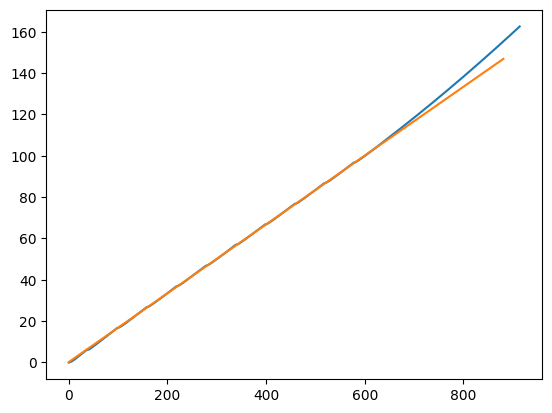

In [42]:
# График предсказаний

# На видео кран начинает двигаться не сразу. А в файле изменение координаты происходит с самого начала.
# Поэтому вручную подбираем момент начала движения на видео (от него прямо зависит сдвиг предсказаний)

begin_move = 80
x_poses_front = np.array(x_poses_front)
plt.figure()
plt.plot(np.arange(0,len(x_poses_front[begin_move:])), x_poses_front[begin_move:])
plt.plot(np.arange(0,len(x_poses_front_gt)), x_poses_front_gt)
# plt.xlim(xmin=164, xmax=225)
# plt.ylim(ymin=25, ymax=40)
plt.show()

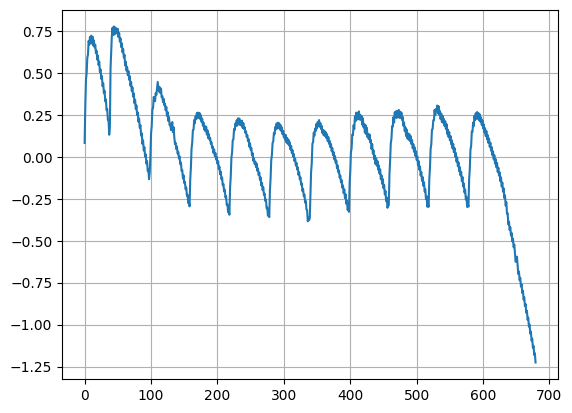

In [43]:
begin_move = 80
end_move = 680
x_poses_front = np.array(x_poses_front)
plt.figure()
resid = x_poses_front_gt[:end_move] - x_poses_front[begin_move:end_move+begin_move]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.show()

In [47]:
cap = cv2.VideoCapture('data/render_distance_long/rear.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter('data/results/demo_rear.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))

estimator_video_rear = PoseSingle(
    aruco_dict_type,
    -1,
    n_markers,
    marker_poses,
    edge_len,
    k,
    d,
    apply_kf = True,
    transition_coef = 50,
    observation_coef = 0.02,
    x_bias = -1.5,
    right_edge_weight_func  = lambda x: np.tanh(10*(1-x-0.35)).clip(min=0),
)

if (cap.isOpened()== False): 
  print("Error opening video stream or file")

x_poses_rear = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame, pose, size = estimator_video_rear(frame, True)
        output = frame
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
            x_poses_rear.append(pose[0][3])
        else:
            x_poses_rear.append(-1)
            
        out.write(output)
    else: 
        break

cap.release()
out.release()

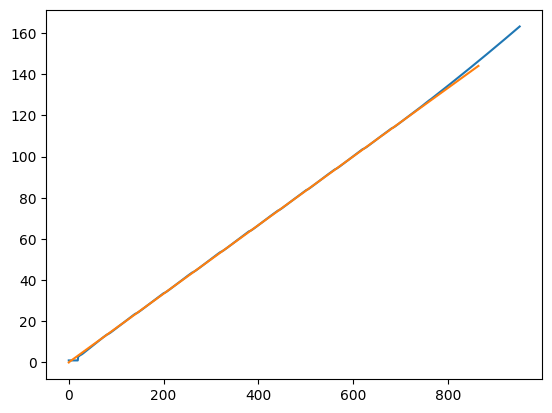

In [48]:
begin_move = 90
x_poses_rear = np.array(x_poses_rear)
plt.plot(np.arange(0,len(x_poses_rear[begin_move:])), x_poses_rear[begin_move:])
plt.plot(np.arange(0,len(x_poses_rear_gt)), x_poses_rear_gt)

plt.show()

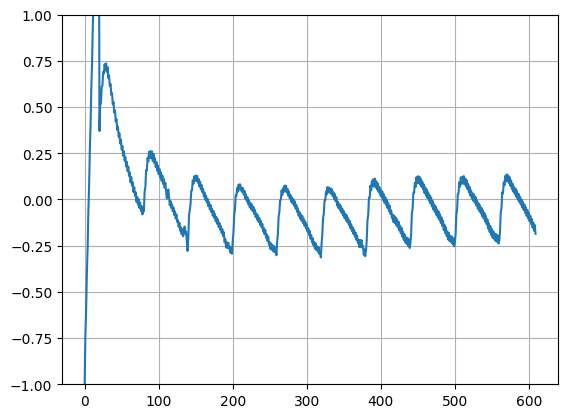

In [49]:
begin_move = 90
end_move = 610
x_poses_rear = np.array(x_poses_rear)
plt.figure()
resid = x_poses_rear_gt[:end_move] - x_poses_rear[begin_move:end_move+begin_move]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.ylim(ymin=-1, ymax=1)
plt.show()

In [50]:
# Среднее
begin_move_front = 80
begin_move_rear = 90
mean_x = np.mean([np.array(x_poses_rear[begin_move_rear:600+begin_move_rear]), np.array(x_poses_front[begin_move_front:600+begin_move_front])], axis=0)

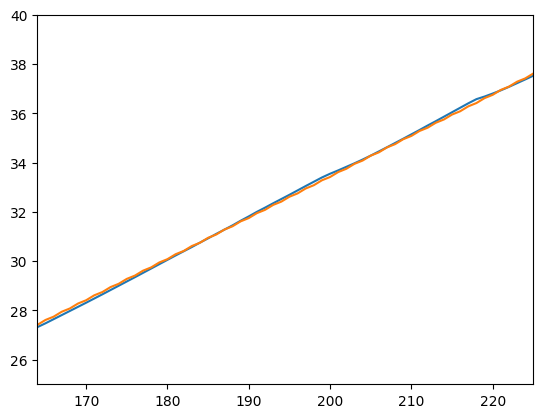

In [51]:
plt.plot(np.arange(0,len(mean_x)), mean_x)
plt.plot(np.arange(0,len(x_poses_front_gt)), x_poses_front_gt)
plt.xlim(xmin=164, xmax=225)
plt.ylim(ymin=25, ymax=40)
plt.show()

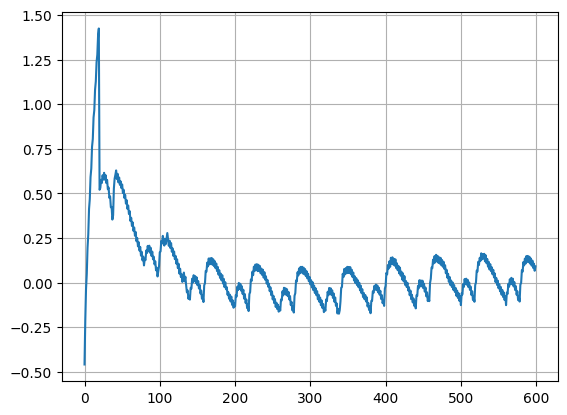

In [52]:
plt.figure()
resid = x_poses_front_gt[:600] - mean_x[:600]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.show()

In [95]:
# Тест с обновленными краевыми функциями БЕЗ фильтра калмана

In [55]:
cap = cv2.VideoCapture('data/render_distance_long/front.mp4')
out = cv2.VideoWriter('data/results/demo_front_nokf.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width,height))

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

estimator_video_front = PoseSingle(
    aruco_dict_type,
    1,
    n_markers,
    marker_poses,
    edge_len,
    k,
    d,
    apply_kf = False,
    transition_coef = 50,
    observation_coef = 0.02,
    x_bias = 1.25,
    left_edge_weight_func  = f_left_x_04,
)

if (cap.isOpened()== False): 
  print("Error opening video stream or file")

x_poses_front = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame, pose, size = estimator_video_front(frame, True)
        output = frame
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
            x_poses_front.append(pose[0][3])
        else:
            x_poses_front.append(-1)
            
        out.write(output)
    else: 
        break

cap.release()
out.release()

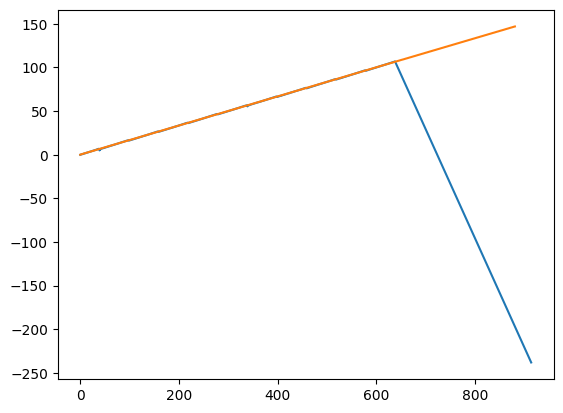

In [56]:
begin_move = 80
x_poses_front = np.array(x_poses_front)
plt.figure()
plt.plot(np.arange(0,len(x_poses_front[begin_move:])), x_poses_front[begin_move:])
plt.plot(np.arange(0,len(x_poses_front_gt)), x_poses_front_gt)
plt.show()

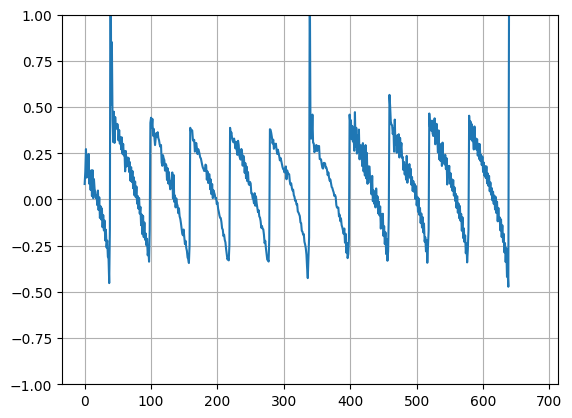

In [57]:
begin_move = 80
end_move = 680
x_poses_front = np.array(x_poses_front)
plt.figure()
resid = x_poses_front_gt[:end_move] - x_poses_front[begin_move:end_move+begin_move]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.ylim(ymin=-1, ymax=1)
plt.show()

In [58]:
cap = cv2.VideoCapture('data/render_distance_long/rear.mp4')
out = cv2.VideoWriter('data/results/demo_rear_nokf.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width,height))

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

estimator_video_rear = PoseSingle(
    aruco_dict_type,
    -1,
    n_markers,
    marker_step,
    edge_len,
    k,
    d,
    apply_kf = False,
    transition_coef = 50,
    observation_coef = 0.02,
    x_bias = -1.5,
    right_edge_weight_func  = lambda x: np.tanh(10*(1-x-0.35)).clip(min=0),
)

if (cap.isOpened()== False): 
  print("Error opening video stream or file")

x_poses_rear = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frame, pose, size = estimator_video_rear(frame, True)
        output = frame
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
            x_poses_rear.append(pose[0][3])
        else:
            x_poses_rear.append(-1)
            
        out.write(output)
    else: 
        break

cap.release()
out.release()

TypeError: PoseSingle.__init__() got an unexpected keyword argument 'right_egde_weight_func'

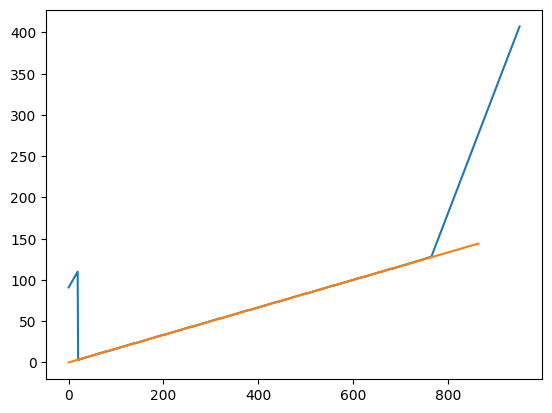

In [ ]:
begin_move = 90
x_poses_rear = np.array(x_poses_rear)
plt.plot(np.arange(0,len(x_poses_rear[begin_move:])), x_poses_rear[begin_move:])
plt.plot(np.arange(0,len(x_poses_rear_gt)), x_poses_rear_gt)

plt.show()

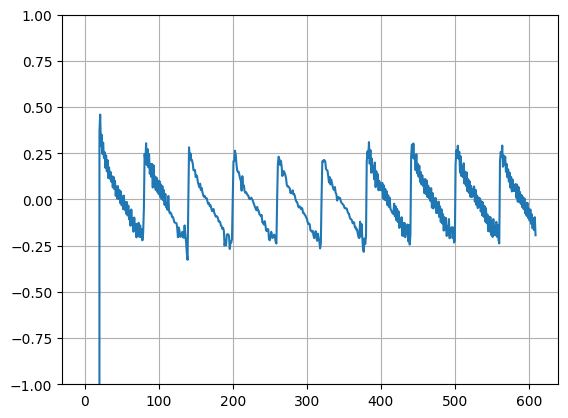

In [ ]:
begin_move = 90
end_move = 610
x_poses_rear = np.array(x_poses_rear)
plt.figure()
resid = x_poses_rear_gt[:end_move] - x_poses_rear[begin_move:end_move+begin_move]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.ylim(ymin=-1, ymax=1)
plt.show()

In [ ]:
# Среднее
begin_move_front = 80
begin_move_rear = 90
mean_x = np.mean([np.array(x_poses_rear[begin_move_rear:600+begin_move_rear]), np.array(x_poses_front[begin_move_front:600+begin_move_front])], axis=0)

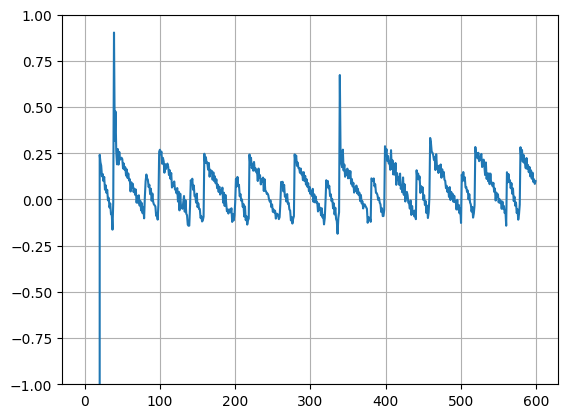

In [ ]:
plt.figure()
resid = x_poses_front_gt[:600] - mean_x[:600]
plt.plot(np.arange(0,len(resid)), resid)
plt.grid(True)
plt.ylim(ymin=-1, ymax=1)
plt.show()